In [1]:
# coding=utf-8
from __future__ import print_function, absolute_import 
from gm.api import *

In [2]:
import numpy as np
import pandas as pd

In [3]:
set_token('9c0950e38c59552734328ad13ad93b6cc44ee271')
# 基础交易数据

In [4]:
# context.symbol = 'SHSE.510300'
start_date = '2018-02-28'
end_date =  '2020-02-28'

In [5]:
trade_data = history('SHSE.510300', frequency='1d', start_time=start_date, end_time=end_date, fill_missing='last',
                         df=True)
# 去除 'symbol', 'eob', 'frequency','position' 列
trade_data.drop(['symbol', 'eob', 'frequency','position'], axis=1, inplace=True)
# 将'bob'去时区化后作为索引
trade_data.set_index('bob', inplace=True)
# 将data的索引设置为tz-naive
trade_data.index = trade_data.index.tz_localize(None)


In [6]:

trade_data

,open,high,low,close,volume,amount,pre_close
bob,,,,,,,
2018-02-28,4.028,4.055,3.995,4.020,239224566,962934464.0,4.061
2018-03-01,4.000,4.067,3.993,4.049,118636949,479103440.0,4.020
2018-03-02,4.020,4.043,4.008,4.022,90614682,364642464.0,4.049
2018-03-05,4.025,4.049,3.990,4.013,96012470,385767888.0,4.022
2018-03-06,4.042,4.074,3.997,4.073,133593823,539875120.0,4.013
...,...,...,...,...,...,...,...
2020-02-24,4.123,4.136,4.082,4.112,372727296,1532512768.0,4.145
2020-02-25,4.051,4.116,4.012,4.104,603830768,2459159328.0,4.112
2020-02-26,4.064,4.118,4.048,4.070,641793392,2617010928.0,4.104


In [7]:
data = trade_data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2018-02-28 to 2020-02-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       487 non-null    float64
 1   high       487 non-null    float64
 2   low        487 non-null    float64
 3   close      487 non-null    float64
 4   volume     487 non-null    int64  
 5   amount     487 non-null    float64
 6   pre_close  487 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 30.4 KB


# 添加输出/监督变量：未来T日的平均收益率

In [8]:
def add_return_column(data, T=3):
    """
    向DataFrame添加未来T日的平均日收益率。

    参数:
    - data: 包含交易数据的DataFrame。
    - T: 未来的天数，默认为3。

    返回值:
    - 该函数没有返回值，但会修改传入的DataFrame，为每个交易日添加一个新列，表示未来T日的收益率。
    """
    # (1+avg)^T = (1+y) = close(T)/close 
    # 取对数，T ln(1+avg) = ln(1+y)
    # 对于较小量，ln(1+x) ≈ x
    # 所以 avg = y/T =(close(T)/close-1)/T
    data['avg_daily_return_'+str(T)] = (data['close'].shift(-T)/data['close']-1)/T

In [9]:
T = 3
add_return_column(data,T)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2018-02-28 to 2020-02-28
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                487 non-null    float64
 1   high                487 non-null    float64
 2   low                 487 non-null    float64
 3   close               487 non-null    float64
 4   volume              487 non-null    int64  
 5   amount              487 non-null    float64
 6   pre_close           487 non-null    float64
 7   avg_daily_return_3  484 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 34.2 KB


# 添加技术指标

In [10]:
def add_ma_columns(data, ma_periods):
    """
    向DataFrame添加移动平均列。

    参数:
    - data: 包含交易数据的DataFrame。
    - ma_periods: 一个包含要计算的移动平均周期的列表，每个元素是一个整数，表示天数。

    返回值:
    - 该函数没有返回值，但会修改传入的DataFrame，为每个指定的周期添加一个新列。
    """
    for period in ma_periods:
        ma_column_name = f'MA_{period}'  # 根据周期生成列名称，如'MA_5'表示5天移动平均
        data[ma_column_name] = data['close'].rolling(window=period).mean()

def add_ema_columns(data, ema_periods):
    """
    向DataFrame添加指数移动平均列。

    参数:
    - data: 包含交易数据的DataFrame。
    - ema_periods: 一个包含要计算的指数移动平均周期的列表，每个元素是一个整数，表示天数。

    返回值:
    - 该函数没有返回值，但会修改传入的DataFrame，为每个指定的周期添加一个新列。
    """
    for period in ema_periods:
        ema_column_name = f'EMA_{period}'  # 根据周期生成列名称，如'EMA_5'表示5天指数移动平均
        data[ema_column_name] = data['close'].ewm(span=period).mean()

def add_rsi_factor(data, period=14):
    """
    向DataFrame添加相对强弱指数（RSI）因子。

    参数:
    - data: 包含交易数据的DataFrame。
    - period: 计算RSI的周期，默认为14天。
    """
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

def add_atr_factor(data, period=14):
    """
    向DataFrame添加平均真实范围（ATR）因子。

    参数:
    - data: 包含交易数据的DataFrame。
    - period: 计算ATR的周期，默认为14天。
    """
    high_low = data['high'] - data['low']
    high_close = (data['high'] - data['close'].shift()).abs()
    low_close = (data['low'] - data['close'].shift()).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=period).mean()

def add_bollinger_band_width_factor(data, period=20, num_std=2):
    """
    向DataFrame添加布林带宽度因子。

    参数:
    - data: 包含交易数据的DataFrame。
    - period: 计算布林带的周期，默认为20天。
    - num_std: 布林带的标准差倍数，默认为2。
    """
    ma = data['close'].rolling(window=period).mean()
    std = data['close'].rolling(window=period).std()
    upper_band = ma + (std * num_std)
    lower_band = ma - (std * num_std)
    data['Bollinger_Width'] = upper_band - lower_band

def add_vwap_factor(data):
    """
    向DataFrame添加成交量加权平均价格（VWAP）因子。

    参数:
    - data: 包含交易数据的DataFrame。
    """
    data['VWAP'] = (data['volume'] * data['close']).cumsum() / data['volume'].cumsum()


In [11]:
add_ma_columns(data, [5, 10, 20, 60, 120])
add_ema_columns(data, [5, 10, 20, 60, 120])
add_rsi_factor(data)
add_atr_factor(data)
add_bollinger_band_width_factor(data)
add_vwap_factor(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2018-02-28 to 2020-02-28
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                487 non-null    float64
 1   high                487 non-null    float64
 2   low                 487 non-null    float64
 3   close               487 non-null    float64
 4   volume              487 non-null    int64  
 5   amount              487 non-null    float64
 6   pre_close           487 non-null    float64
 7   avg_daily_return_3  484 non-null    float64
 8   MA_5                483 non-null    float64
 9   MA_10               478 non-null    float64
 10  MA_20               468 non-null    float64
 11  MA_60               428 non-null    float64
 12  MA_120              368 non-null    float64
 13  EMA_5               487 non-null    float64
 14  EMA_10              487 non-null    float64
 15  EMA_20              487 non-null    fl

# 添加EMD分解 (库安装有问题，废弃)

In [1]:
from PyEMD import EMD


ModuleNotFoundError: No module named 'PyEMD'

In [4]:
def add_emd_columns(data, baseColumn):
    """
    向DataFrame添加EMD分解列。

    参数:
    - data: 包含交易数据的DataFrame。
    - baseColumn: 一个字符串，表示要分解的基础列。

    返回值:
    - 该函数没有返回值，但会修改传入的DataFrame，为每个IMF和剩余部分添加一个新列。
    """
    
    emd = EMD()
    imfs = emd(data[baseColumn].values)
    for i, imf in enumerate(imfs):
        data[f'IMF_{i+1}'] = imf
    data['Residual'] = data[baseColumn] - sum(imfs)
        
add_emd_columns(data, 'close')

ModuleNotFoundError: No module named 'PyEMD'

# 宏观数据指标

In [179]:
macro_data = pd.read_excel('../data/macro.xlsx')

In [180]:
#date作为索引
macro_data.set_index('date', inplace=True)

In [181]:
# 查看date是否为tz-aware
try:
    macro_data.index.tz_localize('UTC')
    print("The 'date' index is not tz-aware.")
except TypeError:
    print("The 'date' index is tz-aware.")

The 'date' index is not tz-aware.


In [182]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3252 entries, 2015-05-08 to 2024-04-01
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bdi                       3252 non-null   int64  
 1   chibor_1M                 3252 non-null   float64
 2   chibor_1Y                 3252 non-null   float64
 3   chibor_1w                 3252 non-null   float64
 4   chibor_2M                 3252 non-null   float64
 5   chibor_2w                 3252 non-null   float64
 6   chibor_3M                 3252 non-null   float64
 7   chibor_3w                 3252 non-null   float64
 8   chibor_4M                 3252 non-null   float64
 9   chibor_6M                 3252 non-null   float64
 10  chibor_9M                 3252 non-null   float64
 11  chibor_on                 3252 non-null   float64
 12  cpi                       3252 non-null   float64
 13  end_investor_num          3252 non-null   flo

In [183]:
# 查看data中的索引date是否为tz-aware
try:
    data.index.tz_localize('UTC')
    print("The 'date' index is not tz-aware.")
except TypeError:
    print("The 'date' index is tz-aware.")
    print(macro_data.index.tz)

The 'date' index is not tz-aware.


In [184]:
# 将macro_data根据日期与data合并
data = data.join(macro_data, how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2018-02-28 to 2020-02-28
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      487 non-null    float64
 1   high                      487 non-null    float64
 2   low                       487 non-null    float64
 3   close                     487 non-null    float64
 4   volume                    487 non-null    int64  
 5   amount                    487 non-null    float64
 6   pre_close                 487 non-null    float64
 7   avg_daily_return_3        484 non-null    float64
 8   MA_5                      483 non-null    float64
 9   MA_10                     478 non-null    float64
 10  MA_20                     468 non-null    float64
 11  MA_60                     428 non-null    float64
 12  MA_120                    368 non-null    float64
 13  EMA_5                     487 non-null    floa

In [185]:
# 分别从macro_data、data中取2020-01-02的bdi数据验证是否合并正确
print(data.loc['2020-01-02', 'bdi'])
print(macro_data.loc['2020-01-02', 'bdi'])

1090.0
1090.0


# 情绪数据

AK恐惧贪婪指数只能获取到22年后，暂不考虑了

In [186]:
def calculate_ar(data, period=26):
    """
    计算AR（人气指标）。

    参数:
    - data: 包含'high', 'low', 'open'列的DataFrame。
    - period: 计算指标的周期，默认为26天。

    返回:
    - ar: DataFrame，包含计算周期内的AR值。
    """
    ar_numerator = (data['high'] - data['open']).rolling(window=period).sum()
    ar_denominator = (data['open'] - data['low']).rolling(window=period).sum()
    ar = (ar_numerator / ar_denominator) * 100
    return ar


In [187]:
def calculate_br(data, period=26):
    """
    计算BR（意愿指标）。

    参数:
    - data: 包含'high', 'low', 'close'列的DataFrame。
    - period: 计算指标的周期，默认为26天。

    返回:
    - br: DataFrame，包含计算周期内的BR值。
    """
    br_numerator = (data['high'] - data['close'].shift()).rolling(window=period).sum()
    br_denominator = (data['close'].shift() - data['low']).rolling(window=period).sum()
    br = (br_numerator / br_denominator) * 100
    return br


In [188]:
# 加入到data中
data['AR'] = calculate_ar(data)
data['BR'] = calculate_br(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2018-02-28 to 2020-02-28
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      487 non-null    float64
 1   high                      487 non-null    float64
 2   low                       487 non-null    float64
 3   close                     487 non-null    float64
 4   volume                    487 non-null    int64  
 5   amount                    487 non-null    float64
 6   pre_close                 487 non-null    float64
 7   avg_daily_return_3        484 non-null    float64
 8   MA_5                      483 non-null    float64
 9   MA_10                     478 non-null    float64
 10  MA_20                     468 non-null    float64
 11  MA_60                     428 non-null    float64
 12  MA_120                    368 non-null    float64
 13  EMA_5                     487 non-null    floa

# 特征工程

In [189]:
data

,open,high,low,close,volume,amount,pre_close,avg_daily_return_3,MA_5,MA_10,...,gdp,gold_reserve,m0,m1,m2,new_investors_num,pmi,ppi,AR,BR
bob,,,,,,,,,,,,,,,,,,,,,
2018-02-28,4.028,4.055,3.995,4.020,239224566,962934464.0,4.061,-0.00058043,NaN,NaN,...,6.8,5924,13.5,8.5,8.8,8.35,51.3,4.3,NaN,NaN
2018-03-01,4.000,4.067,3.993,4.049,118636949,479103440.0,4.020,0.00197580,NaN,NaN,...,6.8,5924,13.5,8.5,8.8,8.35,51.3,4.3,NaN,NaN
2018-03-02,4.020,4.043,4.008,4.022,90614682,364642464.0,4.049,0.00149180,NaN,NaN,...,6.8,5924,13.5,8.5,8.8,30.77,51.3,4.3,NaN,NaN
2018-03-05,4.025,4.049,3.990,4.013,96012470,385767888.0,4.022,0.00564831,NaN,NaN,...,6.8,5924,13.5,8.5,8.8,30.77,51.3,4.3,NaN,NaN
2018-03-06,4.042,4.074,3.997,4.073,133593823,539875120.0,4.013,0.00310991,4.0354,NaN,...,6.8,5924,13.5,8.5,8.8,30.77,51.3,4.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,4.123,4.136,4.082,4.112,372727296,1532512768.0,4.145,-0.00332361,4.0934,4.0372,...,6.0,6264,4.7,3.3,8.4,31.61,50.0,0.1,134.10641201,57.28689276
2020-02-25,4.051,4.116,4.012,4.104,603830768,2459159328.0,4.112,-0.01388889,4.1064,4.0533,...,6.0,6264,4.7,3.3,8.4,31.61,50.0,0.1,138.08255659,51.91163976
2020-02-26,4.064,4.118,4.048,4.070,641793392,2617010928.0,4.104,NaN,4.1124,4.0632,...,6.0,6264,4.7,3.3,8.4,31.61,50.0,0.1,138.56382979,47.41166804


In [190]:
# 去除有空值的行
data.dropna(inplace=True)


In [191]:
data.describe()

,open,high,low,close,volume,amount,pre_close,avg_daily_return_3,MA_5,MA_10,...,gdp,gold_reserve,m0,m1,m2,new_investors_num,pmi,ppi,AR,BR
count,365.00000000,365.00000000,365.00000000,365.00000000,3.65000000e+02,3.65000000e+02,365.00000000,365.00000000,365.00000000,365.00000000,...,365.00000000,365.00000000,365.00000000,365.00000000,365.00000000,365.00000000,365.00000000,365.00000000,365.00000000,365.00000000
mean,3.67913151,3.71008767,3.65294247,3.68303014,3.62470050e+08,1.33714903e+09,3.68055616,0.00057210,3.67864877,3.67405425,...,6.30027397,6093.50410959,3.78328767,3.01342466,8.24356164,28.78180822,50.10904110,0.90520548,119.01608944,115.97857956
std,0.32671218,0.32554891,0.32724650,0.32730006,1.72459950e+08,6.53461826e+08,0.32722779,0.00785982,0.32363523,0.31964760,...,0.21769252,138.47461032,3.51772906,0.80237323,0.19440929,4.34578652,0.73260067,1.97473055,39.34855464,53.62822304
min,3.00100000,3.06100000,2.99700000,3.01700000,1.15650820e+08,3.78852960e+08,3.01700000,-0.03621600,3.04080000,3.06640000,...,6.00000000,5924.00000000,-2.40000000,0.40000000,8.00000000,12.00000000,49.20000000,-1.60000000,57.91556728,35.50000000
25%,3.34800000,3.37800000,3.31400000,3.34800000,2.41440710e+08,8.99467504e+08,3.34600000,-0.00383621,3.33560000,3.34480000,...,6.00000000,5924.00000000,2.80000000,2.70000000,8.00000000,24.57000000,49.70000000,-0.80000000,90.58823529,74.88855869
50%,3.77400000,3.83000000,3.74100000,3.80100000,3.21627392e+08,1.18923360e+09,3.79300000,0.00016746,3.78300000,3.77500000,...,6.40000000,6110.00000000,4.30000000,3.30000000,8.20000000,31.61000000,50.00000000,0.10000000,108.92494929,101.55875300
75%,3.95100000,3.97500000,3.93400000,3.95600000,4.36082928e+08,1.60282989e+09,3.95400000,0.00551391,3.95060000,3.94980000,...,6.40000000,6245.00000000,4.70000000,3.40000000,8.40000000,31.61000000,50.20000000,3.30000000,134.10641201,152.18800648
max,4.20200000,4.22200000,4.18000000,4.20200000,1.47107578e+09,5.43156275e+09,4.20200000,0.03267404,4.17060000,4.16000000,...,6.70000000,6264.00000000,17.20000000,5.10000000,8.50000000,31.61000000,51.50000000,4.60000000,274.84472050,296.27192982


## 数据“打包”，为LSTM做准备

In [192]:
from sklearn.preprocessing import StandardScaler

def pack_data_with_scaling(data, input_columns, output_column, window_size):
    """
    将DataFrame中的数据打包成LSTM的输入和输出，并对每个窗口的输入数据进行标准化处理。
    """
    X = []
    y = []
    scaler = StandardScaler()
    
    for i in range(len(data) - window_size):
        window_data = data[input_columns].iloc[i:i + window_size] #python的区间是左闭右开
        scaled_window_data = scaler.fit_transform(window_data)
        X.append(scaled_window_data)  #只对输入数据进行标准化处理
        y.append(data[output_column].iloc[i + window_size]) 
    
    return np.array(X), np.array(y)

# 选择用于预测的特征列
# input_columns = ['close', 'volume', 'log_return', 'MA_5', 'MA_10', 'MA_20', 'MA_60', 'MA_120',
#                  'EMA_5', 'EMA_10', 'EMA_20', 'EMA_60', 'EMA_120',
#                  'RSI', 'ATR', 'Bollinger_Width', 'VWAP', 'bdi', 'AR', 'BR']
input_columns = data.columns.tolist()
print(input_columns)
output_column = 'avg_daily_return_'+str(T)
# 打包数据
window_size=20
X, y = pack_data_with_scaling(data, input_columns, output_column, window_size)

# 说明：X的形状为(样本数量, 窗口大小, 特征数量)，y的形状为(样本数量,)。
# print这些信息，要对应到“样本数量：”
print(X.shape, y.shape)
print('样本数量：', X.shape[0])
print('窗口大小：', X.shape[1])
print('特征数量：', X.shape[2])

['open', 'high', 'low', 'close', 'volume', 'amount', 'pre_close', 'avg_daily_return_3', 'MA_5', 'MA_10', 'MA_20', 'MA_60', 'MA_120', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_60', 'EMA_120', 'RSI', 'ATR', 'Bollinger_Width', 'VWAP', 'bdi', 'chibor_1M', 'chibor_1Y', 'chibor_1w', 'chibor_2M', 'chibor_2w', 'chibor_3M', 'chibor_3w', 'chibor_4M', 'chibor_6M', 'chibor_9M', 'chibor_on', 'cpi', 'end_investor_num', 'foreign_exchange_reserve', 'gdp', 'gold_reserve', 'm0', 'm1', 'm2', 'new_investors_num', 'pmi', 'ppi', 'AR', 'BR']
(345, 20, 47) (345,)
样本数量： 345
窗口大小： 20
特征数量： 47


## 压缩X，与y合并

In [207]:
def flatten_and_combine_data(X, y, input_columns, output_column, window_size):
    """
    展开时间序列数据并将特征和目标变量合并为一个DataFrame。
    
    参数:
    - X: 时间序列数据的三维numpy数组，形状为(样本数, 时间步数, 特征数)。
    - y: 目标变量的一维numpy数组，形状为(样本数,)。
    - input_columns: 特征列名称的列表。
    - output_column: 输出列的名称。
    - window_size: 窗口大小，即每个样本包含的时间步数。
    
    返回:
    - 一个DataFrame，其中包含展开的特征和目标变量。
    -   一个特征名称的列表。
    """
    
    # 将X压平
    X_flattened = X.reshape(X.shape[0], -1)  # 将X压平

    # 生成展开后的特征名称
    feature_names = [f"{feature}_t-{t}" for feature in input_columns for t in range(window_size, 0, -1)]
    
    # 将X_flattened转换为DataFrame
    X_df = pd.DataFrame(X_flattened, columns=feature_names)
    
    # 将y转换为DataFrame
    y_df = pd.DataFrame(y, columns=[output_column])
    
    # 合并X_df和y_df
    data_combined = pd.concat([X_df, y_df], axis=1)
    # 加上列名
    data_combined.columns = feature_names + [output_column]
    return data_combined, feature_names

def mean_and_combine_data(X, y, input_columns, output_column, window_size):
    """
    计算每个窗口的特征的均值，并将特征和目标变量合并为一个DataFrame。
    
    参数:
    - X: 时间序列数据的三维numpy数组，形状为(样本数, 时间步数, 特征数)。
    - y: 目标变量的一维numpy数组，形状为(样本数,)。
    - input_columns: 特征列名称的列表。
    - output_column: 输出列的名称。
    - window_size: 窗口大小，即每个样本包含的时间步数。
    
    返回:
    - 一个DataFrame，其中包含每个窗口的特征的均值和目标变量。
    -  一个特征名称的列表。
    """
    
    # 计算每个窗口的特征的均值
    X_mean = X.mean(axis=1)
    
    # 将X_mean转换为DataFrame
    X_mean_df = pd.DataFrame(X_mean, columns=input_columns)
    
    # 将y转换为DataFrame
    y_df = pd.DataFrame(y, columns=[output_column])
    
    # 合并X_mean_df和y_df
    data_combined = pd.concat([X_mean_df, y_df], axis=1)
    
    # input_columns中的特征名称加上'_mean'
    input_columns = [f"{col}_mean" for col in input_columns]
    
    # 加上列名
    data_combined.columns = input_columns + [output_column]
    return data_combined, input_columns


data_combined, feature_names = mean_and_combine_data(X, y, input_columns, output_column, window_size)

data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   open_mean                      345 non-null    float64
 1   high_mean                      345 non-null    float64
 2   low_mean                       345 non-null    float64
 3   close_mean                     345 non-null    float64
 4   volume_mean                    345 non-null    float64
 5   amount_mean                    345 non-null    float64
 6   pre_close_mean                 345 non-null    float64
 7   avg_daily_return_3_mean        345 non-null    float64
 8   MA_5_mean                      345 non-null    float64
 9   MA_10_mean                     345 non-null    float64
 10  MA_20_mean                     345 non-null    float64
 11  MA_60_mean                     345 non-null    float64
 12  MA_120_mean                    345 non-null    flo

In [198]:

# 将data_combined中的非数值列转换为数值列，将不能转换的列保存到一个列表

## 分析数据

### 相关性分析

In [208]:
output_column

'avg_daily_return_3'

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关系数矩阵
corr_matrix = data_combined.corr()

In [210]:
# 查看目标变量与其他特征的相关性
target_corr = corr_matrix[output_column].sort_values(ascending=False)
target_corr


avg_daily_return_3               1.00000000
end_investor_num_mean            0.19157062
VWAP_mean                        0.15471270
chibor_9M_mean                   0.12820915
chibor_2w_mean                   0.11194175
chibor_1Y_mean                   0.11193495
avg_daily_return_3_mean          0.08669935
EMA_20_mean                      0.08242856
gold_reserve_mean                0.07199251
pre_close_mean                   0.06287107
MA_5_mean                        0.05568530
open_mean                        0.05514787
close_mean                       0.05196153
MA_20_mean                       0.04508224
m0_mean                          0.04185745
high_mean                        0.03507606
volume_mean                      0.03414294
chibor_1M_mean                   0.03260978
chibor_on_mean                   0.02198478
EMA_5_mean                       0.02082029
low_mean                         0.01241448
ATR_mean                         0.00976766
chibor_2M_mean                  

In [215]:
# 计算相关系数，R2
R2 = target_corr**2
R2

# 查看相关系数较小的特征
low_corr_features = target_corr[target_corr.abs() < 0.1]
low_corr_features

avg_daily_return_3_mean          0.08669935
EMA_20_mean                      0.08242856
gold_reserve_mean                0.07199251
pre_close_mean                   0.06287107
MA_5_mean                        0.05568530
open_mean                        0.05514787
close_mean                       0.05196153
MA_20_mean                       0.04508224
m0_mean                          0.04185745
high_mean                        0.03507606
volume_mean                      0.03414294
chibor_1M_mean                   0.03260978
chibor_on_mean                   0.02198478
EMA_5_mean                       0.02082029
low_mean                         0.01241448
ATR_mean                         0.00976766
chibor_2M_mean                   0.00443443
amount_mean                      0.00250960
new_investors_num_mean           0.00247727
foreign_exchange_reserve_mean    0.00143944
MA_60_mean                      -0.01124498
BR_mean                         -0.01130987
EMA_10_mean                     

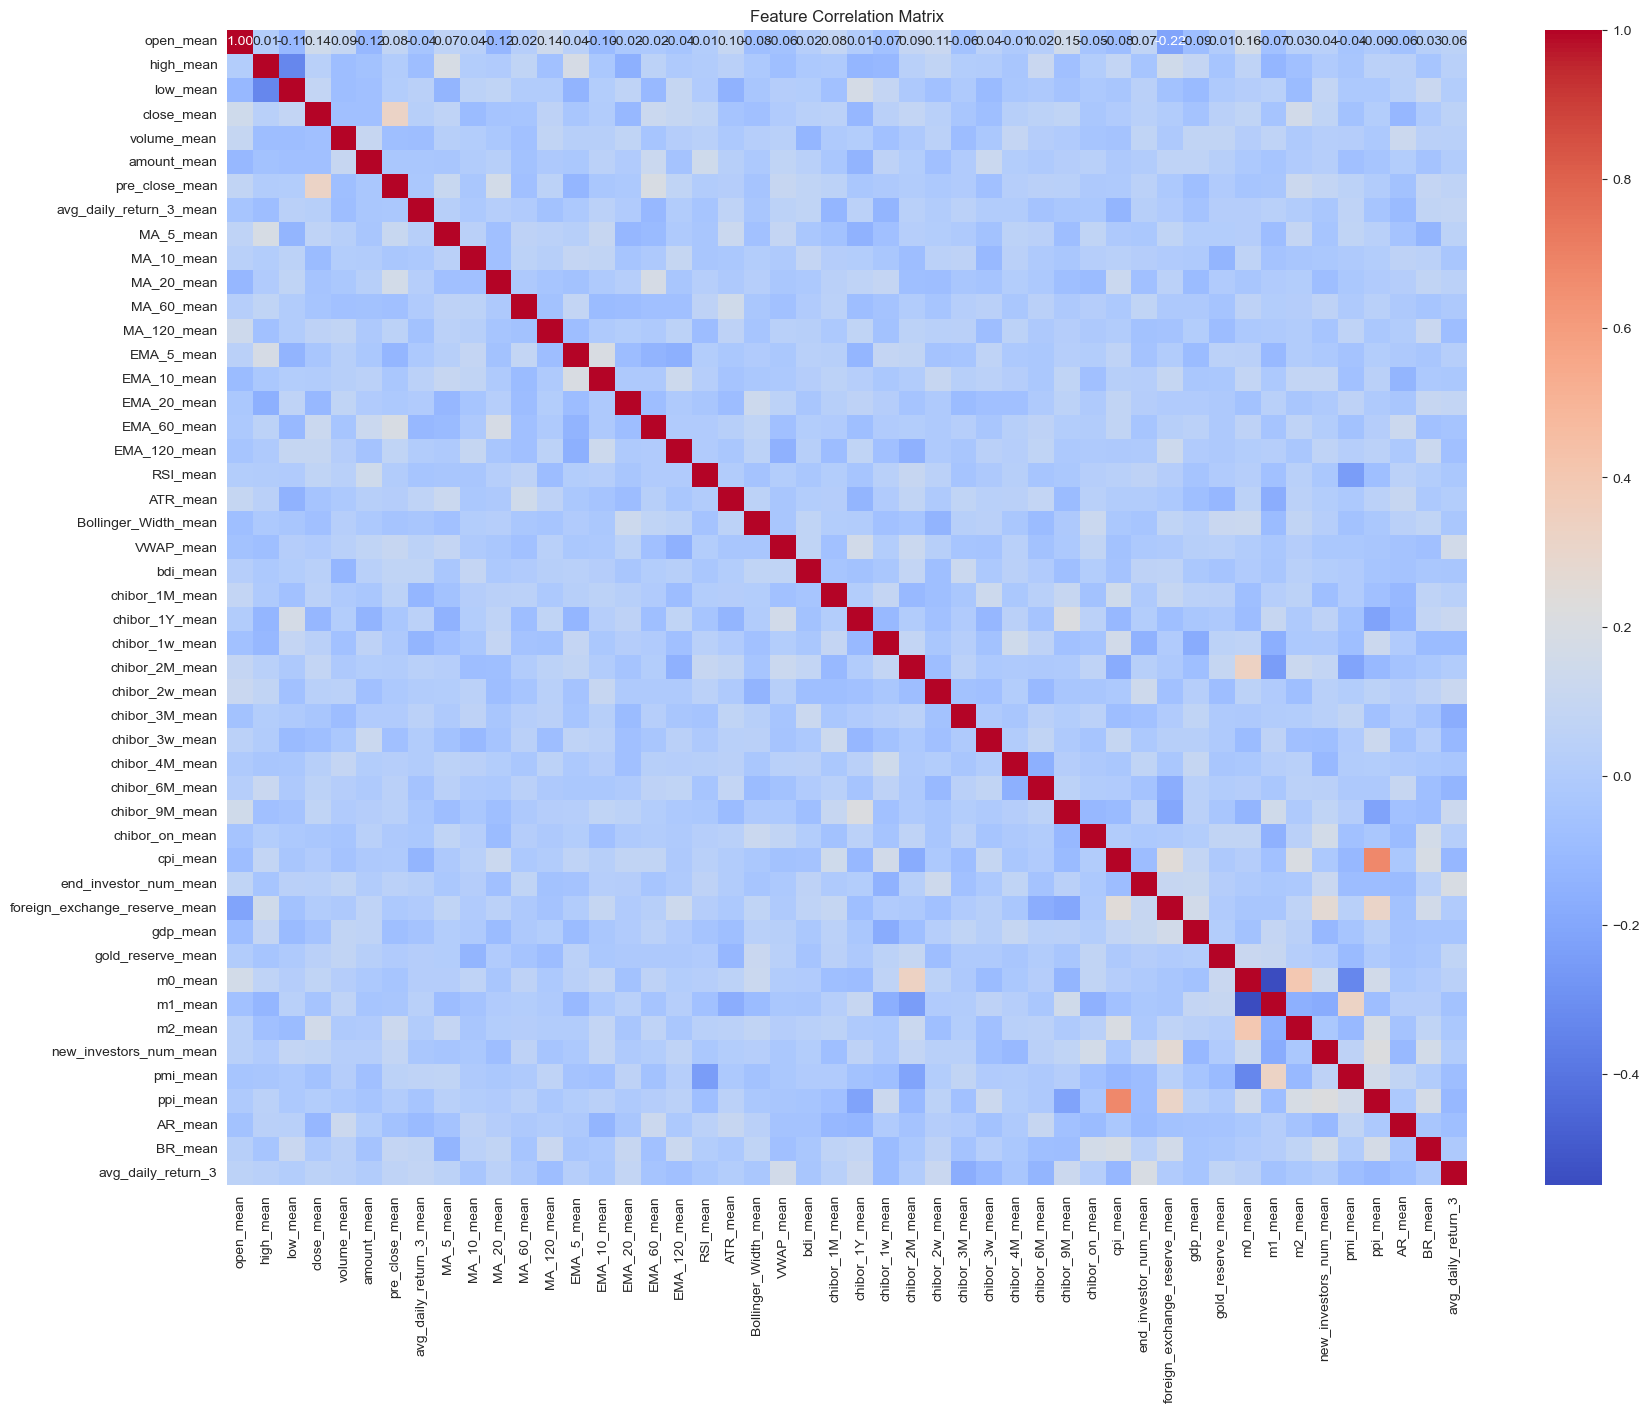

In [216]:
# 设置matplotlib的参数，以确保图形能够适当显示
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [217]:
data_combined.corr()

,open_mean,high_mean,low_mean,close_mean,volume_mean,amount_mean,pre_close_mean,avg_daily_return_3_mean,MA_5_mean,MA_10_mean,...,gold_reserve_mean,m0_mean,m1_mean,m2_mean,new_investors_num_mean,pmi_mean,ppi_mean,AR_mean,BR_mean,avg_daily_return_3
open_mean,1.00000000,0.00944677,-0.11391151,0.14274174,0.09449667,-0.11658162,0.07681271,-0.04480989,0.06730992,0.03728454,...,0.00821065,0.16102167,-0.06931351,0.03455841,0.03762337,-0.04074322,-0.00428971,-0.06105553,0.02656649,0.05514787
high_mean,0.00944677,1.00000000,-0.33280433,0.03791515,-0.08297784,-0.06148632,0.00534637,-0.08625018,0.18535649,0.01303422,...,-0.04440285,0.06321455,-0.12578456,-0.07206349,-0.00251445,-0.03407193,0.04502336,0.04352280,-0.04416794,0.03507606
low_mean,-0.11391151,-0.33280433,1.00000000,0.08149745,-0.08548727,-0.07529851,0.01240167,0.04322789,-0.13201203,0.05523732,...,-0.00459085,0.01991322,0.03615676,-0.09539030,0.08417908,-0.02056135,-0.01663490,0.03410449,0.11298611,0.01241448
close_mean,0.14274174,0.03791515,0.08149745,1.00000000,-0.07089890,-0.07233637,0.31836004,0.03136272,0.06815469,-0.09733094,...,0.04439042,0.07382564,-0.04763649,0.15659279,0.07405605,-0.06043109,0.01433940,-0.11933487,-0.00619770,0.05196153
volume_mean,0.09449667,-0.08297784,-0.08548727,-0.07089890,1.00000000,0.10254905,-0.07740383,-0.08571638,0.03249642,0.01024688,...,0.07910975,0.01953993,0.06762361,-0.00754258,0.02088246,0.01731262,-0.01732821,0.12712559,0.04272540,0.03414294
amount_mean,-0.11658162,-0.06148632,-0.07529851,-0.07233637,0.10254905,1.00000000,-0.02904397,-0.02801810,-0.03446896,0.00535549,...,0.02753448,-0.02067723,-0.04383259,0.00127661,0.02179655,-0.07543089,-0.04570223,0.01133176,-0.05310041,0.00250960
pre_close_mean,0.07681271,0.00534637,0.01240167,0.31836004,-0.07740383,-0.02904397,1.00000000,-0.02192145,0.11017263,-0.02915982,...,-0.00137707,-0.04526364,-0.03544719,0.12767867,0.08447592,0.05558676,0.00605208,-0.06217031,0.08890279,0.06287107
avg_daily_return_3_mean,-0.04480989,-0.08625018,0.04322789,0.03136272,-0.08571638,-0.02801810,-0.02192145,1.00000000,0.02676993,-0.02160406,...,0.01845890,0.01597941,0.03835515,0.00268168,-0.02989604,0.06536817,-0.04464433,-0.10481078,0.07702857,0.08669935
MA_5_mean,0.06730992,0.18535649,-0.13201203,0.06815469,0.03249642,-0.03446896,0.11017263,0.02676993,1.00000000,0.04394628,...,0.00947541,0.01607368,-0.09284204,0.08869978,-0.04325933,0.07365787,0.03261884,-0.05446634,-0.13132227,0.05568530
MA_10_mean,0.03728454,0.01303422,0.05523732,-0.09733094,0.01024688,0.00535549,-0.02915982,-0.02160406,0.04394628,1.00000000,...,-0.13342011,0.06358786,-0.05667621,-0.03840402,-0.02560864,-0.00487324,0.01108125,0.05720907,0.04885062,-0.03621238


In [2]:
from data.get_data import get_common_data

data = get_common_data( 'SHSE.510300', '2019-02-28', '2020-02-28',3)
data

,open,high,low,close,volume,amount,pre_close,MA_5,MA_10,MA_20,...,shibor_1w,shibor_2w,shibor_1m,shibor_3m,shibor_6m,shibor_9m,shibor_1y,AR,BR,avg_daily_return_3
bob,,,,,,,,,,,,,,,,,,,,,
2019-08-21,3.841,3.852,3.836,3.842,242245207,931096032.0,3.843,3.8132,3.7707,3.80080,...,2.653,2.754,2.655,2.674,2.734,2.996,3.064,134.58333333,77.04402516,-0.00069408
2019-08-22,3.852,3.855,3.830,3.850,264778500,1017422992.0,3.842,3.8326,3.7831,3.79795,...,2.642,2.754,2.656,2.682,2.741,2.996,3.059,128.07377049,78.65168539,0.00207792
2019-08-23,3.853,3.892,3.843,3.877,285682080,1106705440.0,3.850,3.8542,3.8011,3.79620,...,2.651,2.745,2.663,2.690,2.748,2.996,3.056,136.15702479,89.55223881,-0.00128966
2019-08-26,3.823,3.846,3.816,3.834,267490225,1024561344.0,3.877,3.8492,3.8089,3.79260,...,2.669,2.739,2.660,2.694,2.751,2.995,3.055,128.51323829,66.46884273,0.00147800
2019-08-27,3.849,3.914,3.847,3.874,366176016,1423007680.0,3.834,3.8554,3.8239,3.79010,...,2.687,2.741,2.662,2.700,2.753,2.993,3.055,155.55555556,85.05747126,-0.00111857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-19,4.036,4.069,4.029,4.040,440377232,1783390976.0,4.039,4.0140,3.9670,3.98780,...,2.268,2.134,2.371,2.510,2.618,2.704,2.773,124.37325905,54.01529637,0.00594059
2020-02-20,4.055,4.144,4.039,4.131,605241104,2472181760.0,4.040,4.0502,3.9904,3.98675,...,2.308,2.115,2.359,2.500,2.610,2.697,2.767,131.31868132,60.07604563,-0.00217865
2020-02-21,4.123,4.178,4.117,4.145,444470160,1839049776.0,4.131,4.0838,4.0161,3.98670,...,2.245,2.111,2.343,2.489,2.605,2.692,2.760,143.24712644,67.95634921,-0.00603136
